In [2]:
%matplotlib inline
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
import torch.optim as optim
from torchmetrics import Accuracy
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter


import matplotlib.pyplot as plt
import numpy as np

# Settings 

torch.set_printoptions(precision=3)

In [3]:
transform_normalize = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                download=True, transform=transform_normalize)

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False,
                                 download=True, transform=transform_normalize)

# have train and validation sets
mnist_trainset, mnist_valset = torch.utils.data.random_split(mnist_trainset, [50000, 10000])


classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=64,
                                            shuffle=False, num_workers=2)

valiloader = torch.utils.data.DataLoader(mnist_valset, batch_size=64,
                                            shuffle=True, num_workers=2)

In [17]:
x_train = torch.stack([sample[0] for sample in ConcatDataset([mnist_trainset])])

x_test = torch.stack([sample[0] for sample in ConcatDataset([mnist_testset])])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


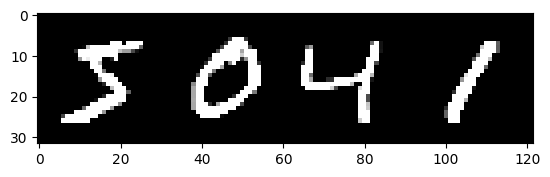

In [14]:
# show image of shape (1, 28, 28)

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(x_train[0:4]))

# MNIST data set

## AlexNet CNN

In [56]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## LeNet-5 CNN  

In [53]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x, return_intermediate=False):
        outputs = {}

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        outputs['conv1'] = x

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        outputs['conv2'] = x

        x = self.flatten(x)
        outputs['flatten'] = x
        
        x = self.fc1(x)
        x = self.relu3(x)
        outputs['fc1'] = x

        x = self.fc2(x)
        x = self.relu4(x)
        outputs['fc2'] = x
 
        x = self.fc3(x)
        outputs['fc3'] = x

        if return_intermediate:
            return outputs, x
        else:
            return  x


In [5]:
class LeNet5V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.feature(x))

In [30]:
# To visualize layers of the network
vis_model = LeNet()
# pass single image through the network
outs, x_out = vis_model(x_train[0:1], return_intermediate=True)

### Layer 1 - Conv2d - before training

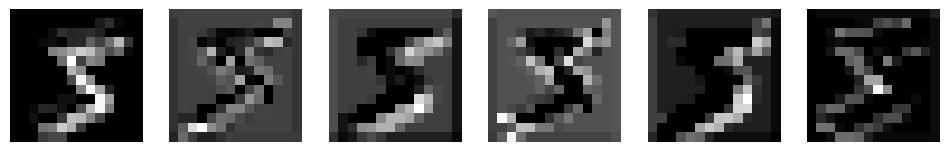

In [31]:
feature_maps = outs['conv1'].detach().cpu().numpy()


fig, axes = plt.subplots(1, len(feature_maps[0]), figsize=(12, 6))
for idx, feature_map in enumerate(feature_maps[0]):
    axes[idx].imshow(feature_map, cmap='gray')
    axes[idx].axis('off')
plt.show()

### Layer 2 - Conv2d - before training

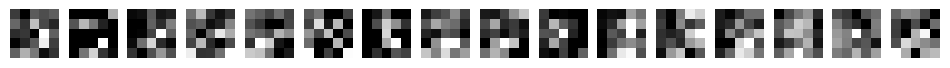

In [32]:
feature_maps = outs['conv2'].detach().cpu().numpy()

fig, axes = plt.subplots(1, len(feature_maps[0]), figsize=(12, 6))
for idx, feature_map in enumerate(feature_maps[0]):
    axes[idx].imshow(feature_map, cmap='gray')
    axes[idx].axis('off')
plt.show()

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
accuracy = Accuracy(task='multiclass', num_classes=10)

accuracy = accuracy.to(device)
model1 = LeNet().to(device)
model5 = LeNet5V1().to(device)


In [9]:
kernels_conv1 = model1.conv1.weight.data.cpu().numpy()

kernels_conv2 = model1.conv2.weight.data.cpu().numpy()

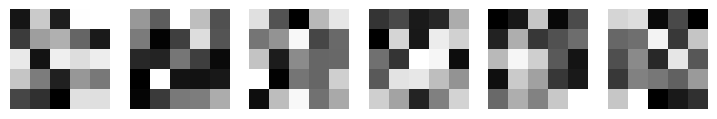

In [10]:
num_kernels = kernels_conv1.shape[0]

# Set up the figure size and grid for subplots
fig, axs = plt.subplots(1, num_kernels, figsize=(num_kernels*1.5, 1.5))

for i, ax in enumerate(axs):
    # Remove axis as we are interested in the patterns
    ax.axis('off')
    
    # Visualize the i-th kernel of the first convolutional layer
    ax.imshow(kernels_conv1[i, 0], cmap='gray')  # Assuming grayscale kernels, adjust if your data has more channels

plt.show()

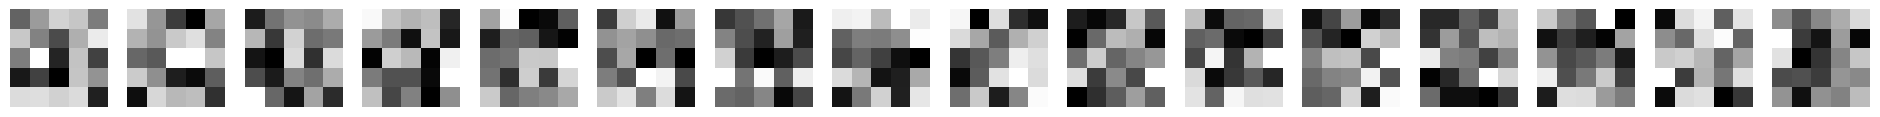

In [11]:
num_kernels = kernels_conv2.shape[0]

# Set up the figure size and grid for subplots
fig, axs = plt.subplots(1, num_kernels, figsize=(num_kernels*1.5, 1.5))

for i, ax in enumerate(axs):
    # Remove axis as we are interested in the patterns
    ax.axis('off')
    
    # Visualize the i-th kernel of the first convolutional layer
    ax.imshow(kernels_conv2[i, 0], cmap='gray')  # Assuming grayscale kernels, adjust if your data has more channels

plt.show()

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters(), lr=0.001)

criterion_second = nn.CrossEntropyLoss()
optimizer_second = torch.optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)




In [51]:
summary(model=model1, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet (LeNet)                            [1, 1, 28, 28]       [1, 10]              --                   True
├─Conv2d (conv1)                         [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
├─ReLU (relu1)                           [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
├─MaxPool2d (pool1)                      [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
├─Conv2d (conv2)                         [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
├─ReLU (relu2)                           [1, 16, 10, 10]      [1, 16, 10, 10]      --                   --
├─MaxPool2d (pool2)                      [1, 16, 10, 10]      [1, 16, 5, 5]        --                   --
├─Flatten (flatten)                      [1, 16, 5, 5]        [1, 400]             --                   --
├─Linear (fc1)          

In [14]:
# Track the loss and accuracy
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = f'LeNet5_MNIST_{timestamp}'
model_name = 'LeNet5'
log_dir = os.path.join('runs', timestamp, experiment_name, model_name)
log_writer = SummaryWriter(log_dir=log_dir)

In [52]:

for epoch in range(10):  # loop over the dataset multiple times
    train_loss, train_acc = 0, 0
    for X, y in trainloader:
        X, y = X.to(device), y.to(device)

        model1.train()
        # model5.train()

        # y_pred = model5(X)
        y_pred = model1(X)

        loss = criterion(y_pred, y)
        train_loss += loss.item()

        acc = accuracy(y_pred, y)
        train_acc += acc

        optimizer_second.zero_grad()
        loss.backward()
        optimizer_second.step()
    
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)
    log_writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss}, global_step=epoch)
    log_writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc}, global_step=epoch)
    print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
    

Epoch 1, Loss: 1.7397, Accuracy: 0.5047
Epoch 2, Loss: 0.2544, Accuracy: 0.9256


In [36]:

for epoch in range(5):  # loop over the dataset multiple times
    
    correct = 0
    total = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)  # Move inputs and labels to the correct device
        model5.train()
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model5(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/10], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')


print('Finished Training')

Epoch [1/10], Loss: 0.0312, Accuracy: 98.97%
Epoch [2/10], Loss: 0.0255, Accuracy: 99.18%
Epoch [3/10], Loss: 0.0233, Accuracy: 99.21%
Epoch [4/10], Loss: 0.0194, Accuracy: 99.35%
Epoch [5/10], Loss: 0.0156, Accuracy: 99.51%
Finished Training


In [53]:
x = x_train[0:1].to(device)
outs_trained, perdictions = model1(x, return_intermediate=True)

### Layer 1 - Conv2d - after training

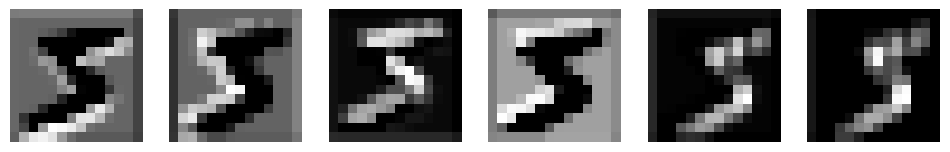

In [59]:
feature_maps_trained = outs_trained['conv1'].detach().cpu().numpy()


fig, axes = plt.subplots(1, len(feature_maps_trained[0]), figsize=(12, 6))
for idx, feature_map in enumerate(feature_maps_trained[0]):
    axes[idx].imshow(feature_map, cmap='gray')
    axes[idx].axis('off')
plt.show()

### Layer 2 - Conv2d - after training

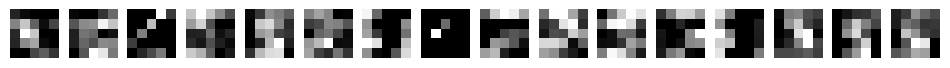

In [60]:
feature_maps_trained = outs_trained['conv2'].detach().cpu().numpy()

fig, axes = plt.subplots(1, len(feature_maps_trained[0]), figsize=(12, 6))
for idx, feature_map in enumerate(feature_maps_trained[0]):
    axes[idx].imshow(feature_map, cmap='gray')
    axes[idx].axis('off')
plt.show()

In [18]:
kernels_conv1_trained = model1.conv1.weight.data.cpu().numpy()

kernels_conv2_trained = model1.conv2.weight.data.cpu().numpy()

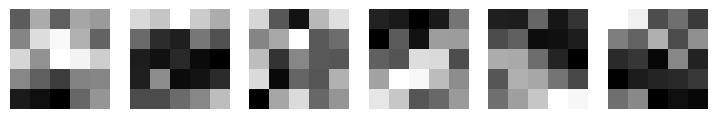

In [19]:
num_kernels = kernels_conv1_trained.shape[0]

# Set up the figure size and grid for subplots
fig, axs = plt.subplots(1, num_kernels, figsize=(num_kernels*1.5, 1.5))

for i, ax in enumerate(axs):
    # Remove axis as we are interested in the patterns
    ax.axis('off')
    
    # Visualize the i-th kernel of the first convolutional layer
    ax.imshow(kernels_conv1_trained[i, 0], cmap='gray')  # Assuming grayscale kernels, adjust if your data has more channels

plt.show()

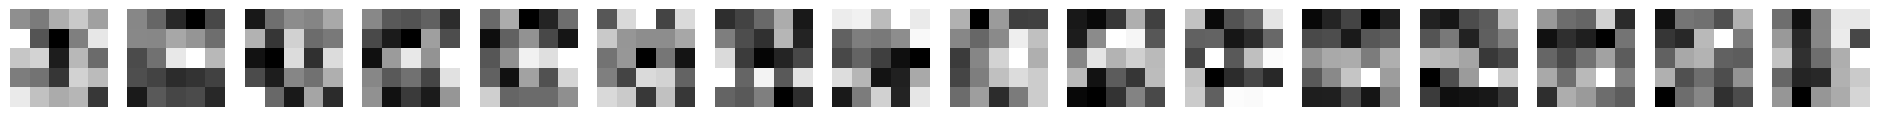

In [20]:
num_kernels = kernels_conv2_trained.shape[0]

# Set up the figure size and grid for subplots
fig, axs = plt.subplots(1, num_kernels, figsize=(num_kernels*1.5, 1.5))

for i, ax in enumerate(axs):
    # Remove axis as we are interested in the patterns
    ax.axis('off')
    
    # Visualize the i-th kernel of the first convolutional layer
    ax.imshow(kernels_conv2_trained[i, 0], cmap='gray')  # Assuming grayscale kernels, adjust if your data has more channels

plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir={log_dir}

In [40]:
torch.save(model5.state_dict(), 'model.pth')

In [48]:
# Clean cude
torch.cuda.empty_cache()

# CIFAR10